# Example of extracting table data from Microsoft DOCX documents

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [2]:
import os
import sys

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [4]:
# install from PYPI using secret
#%pip install spark-ocr==$version\.spark24 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [ ]:
# or install from local path
# %pip install ../../python/dist/spark-ocr-1.10.0.spark24.tar.gz

## Initialization of spark session

In [3]:
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

Spark version: 2.4.4
Spark NLP version: 2.5.5
Spark OCR version: 1.9.0



## Import OCR transformers

In [5]:
from sparkocr.transformers import *
from sparkocr.utils import display_image
from pyspark.sql.functions import collect_list,col

## Read DOCX document as binary file

In [6]:
import pkg_resources
doc_example = pkg_resources.resource_filename('sparkocr', 'resources/ocr/docs/doc2.docx')
doc_example_df = spark.read.format("binaryFile").load(doc_example).cache()

## Preview document using `DocToPdf` and `PdfToImage` transformers

Image:
        origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx 
        width: 2550
        height: 3299
        mode: 10


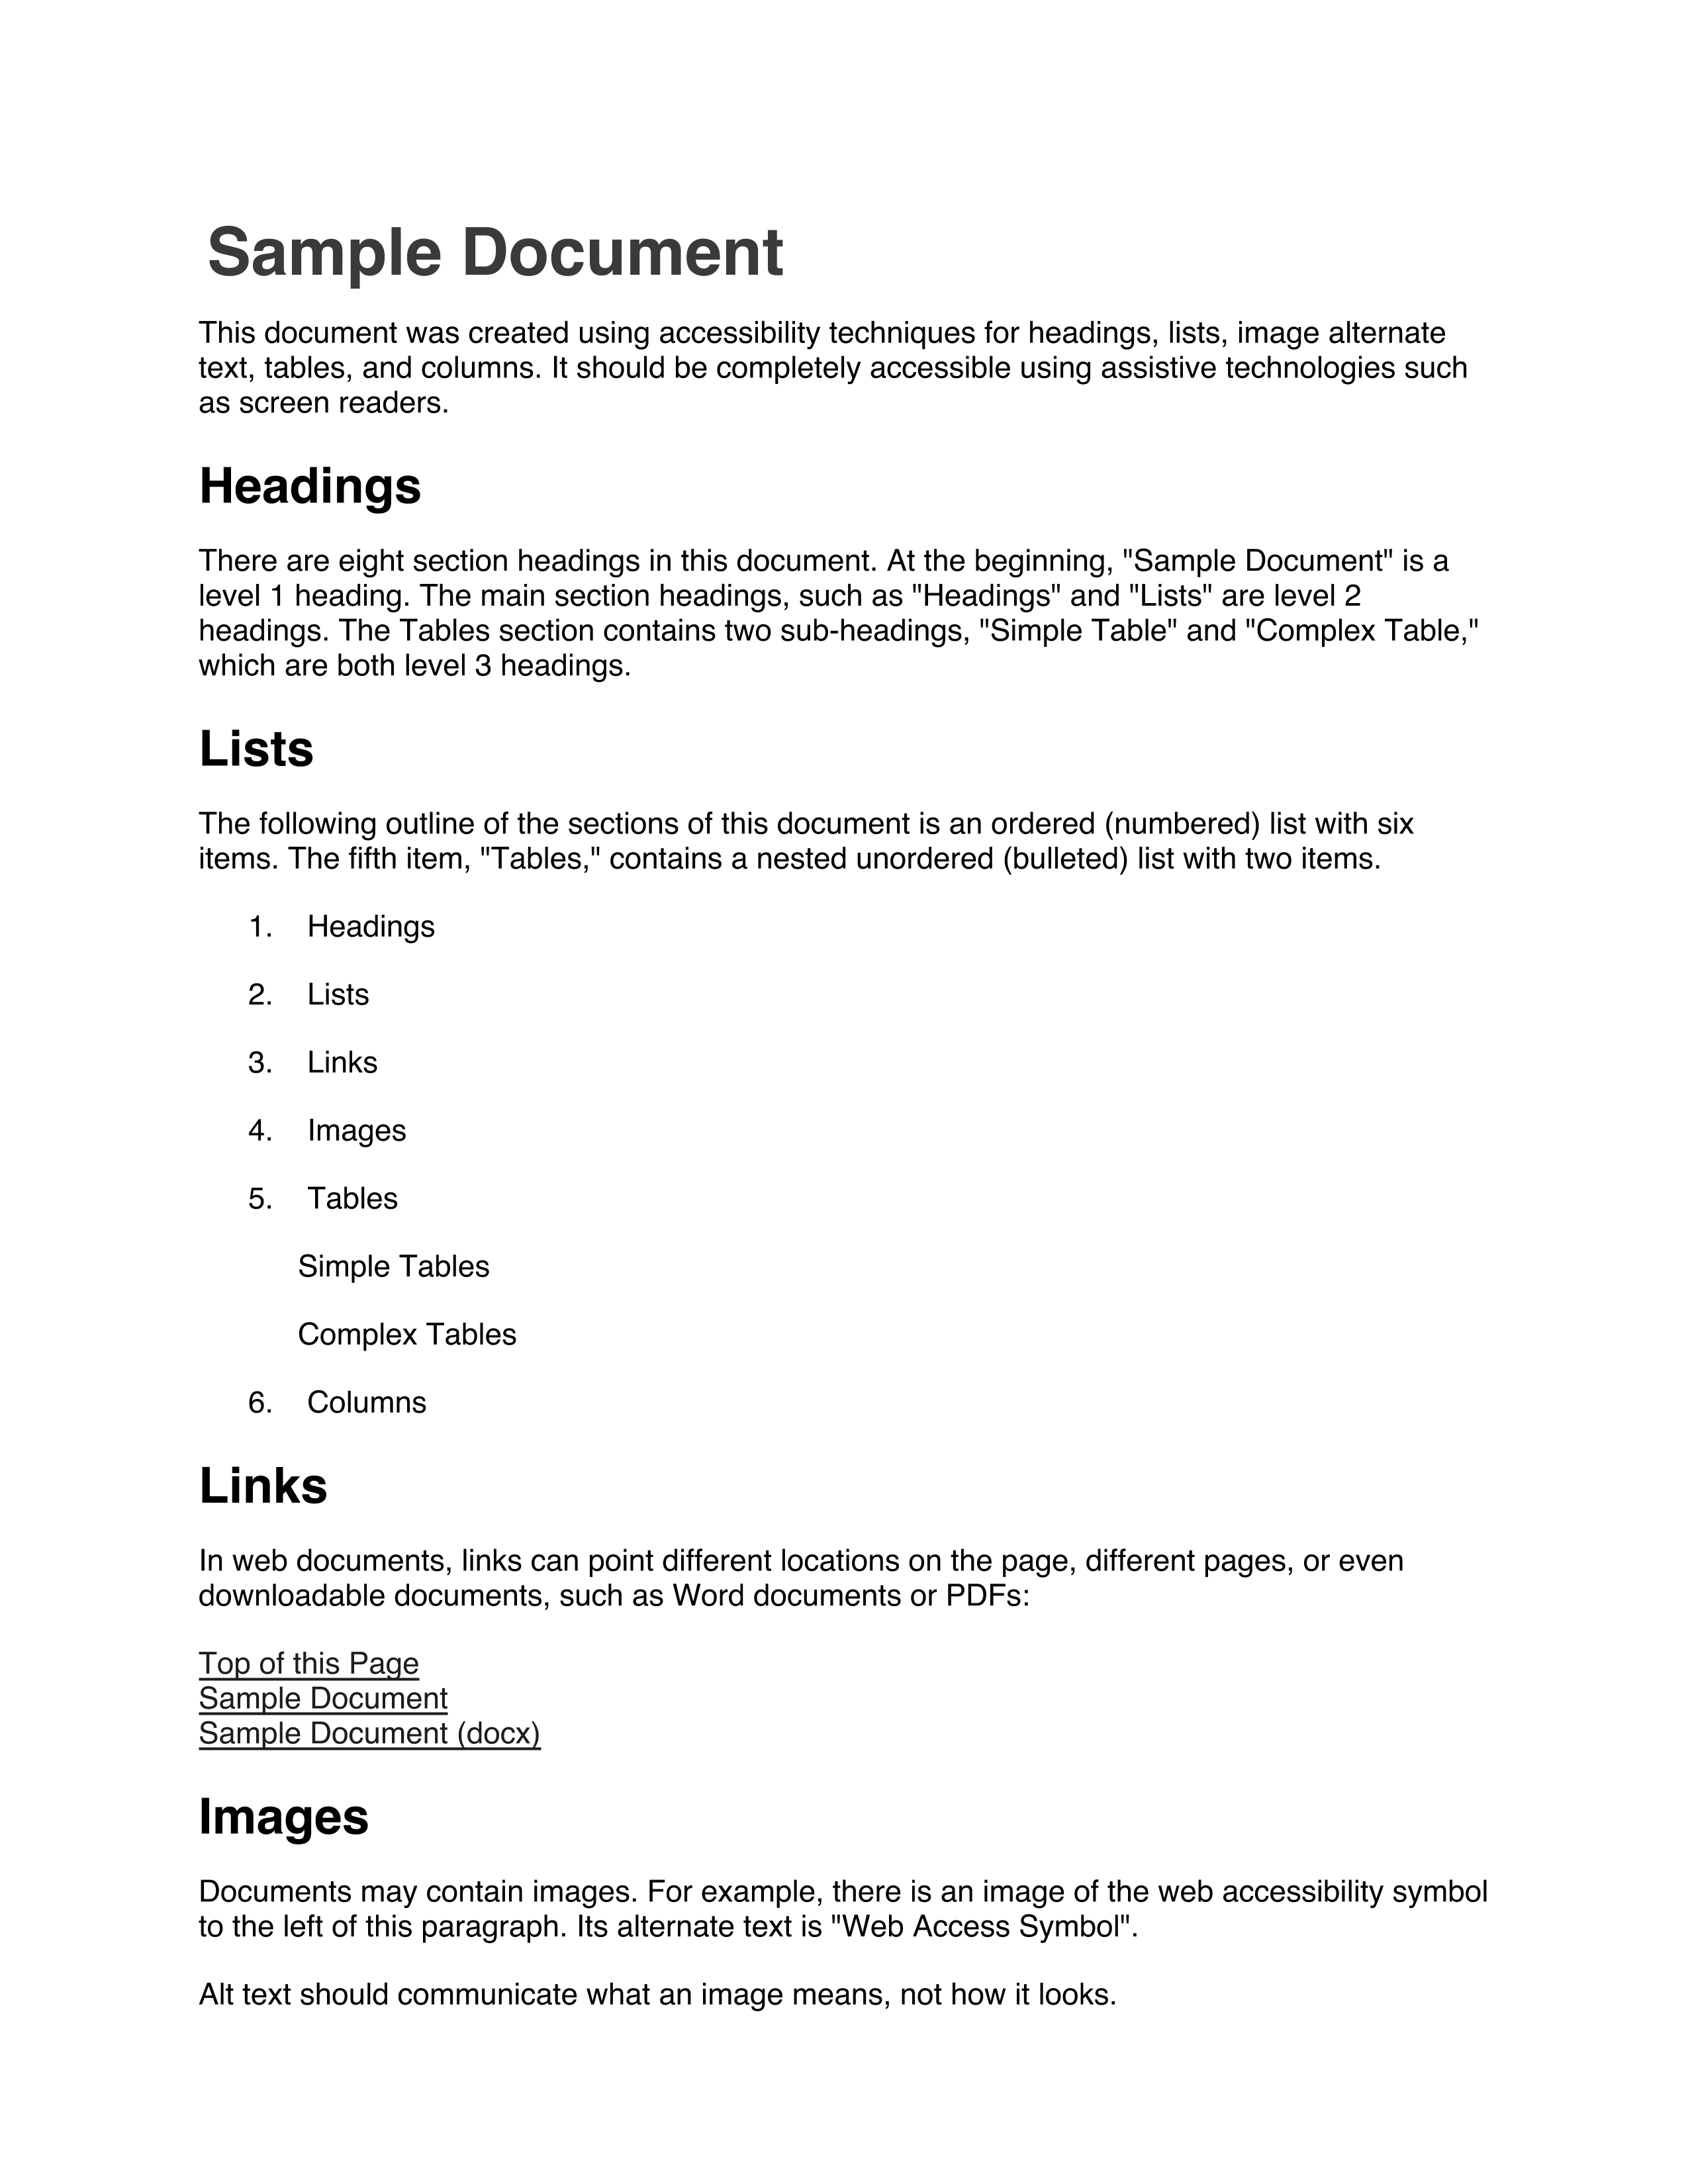

Image:
        origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx 
        width: 2550
        height: 3299
        mode: 10


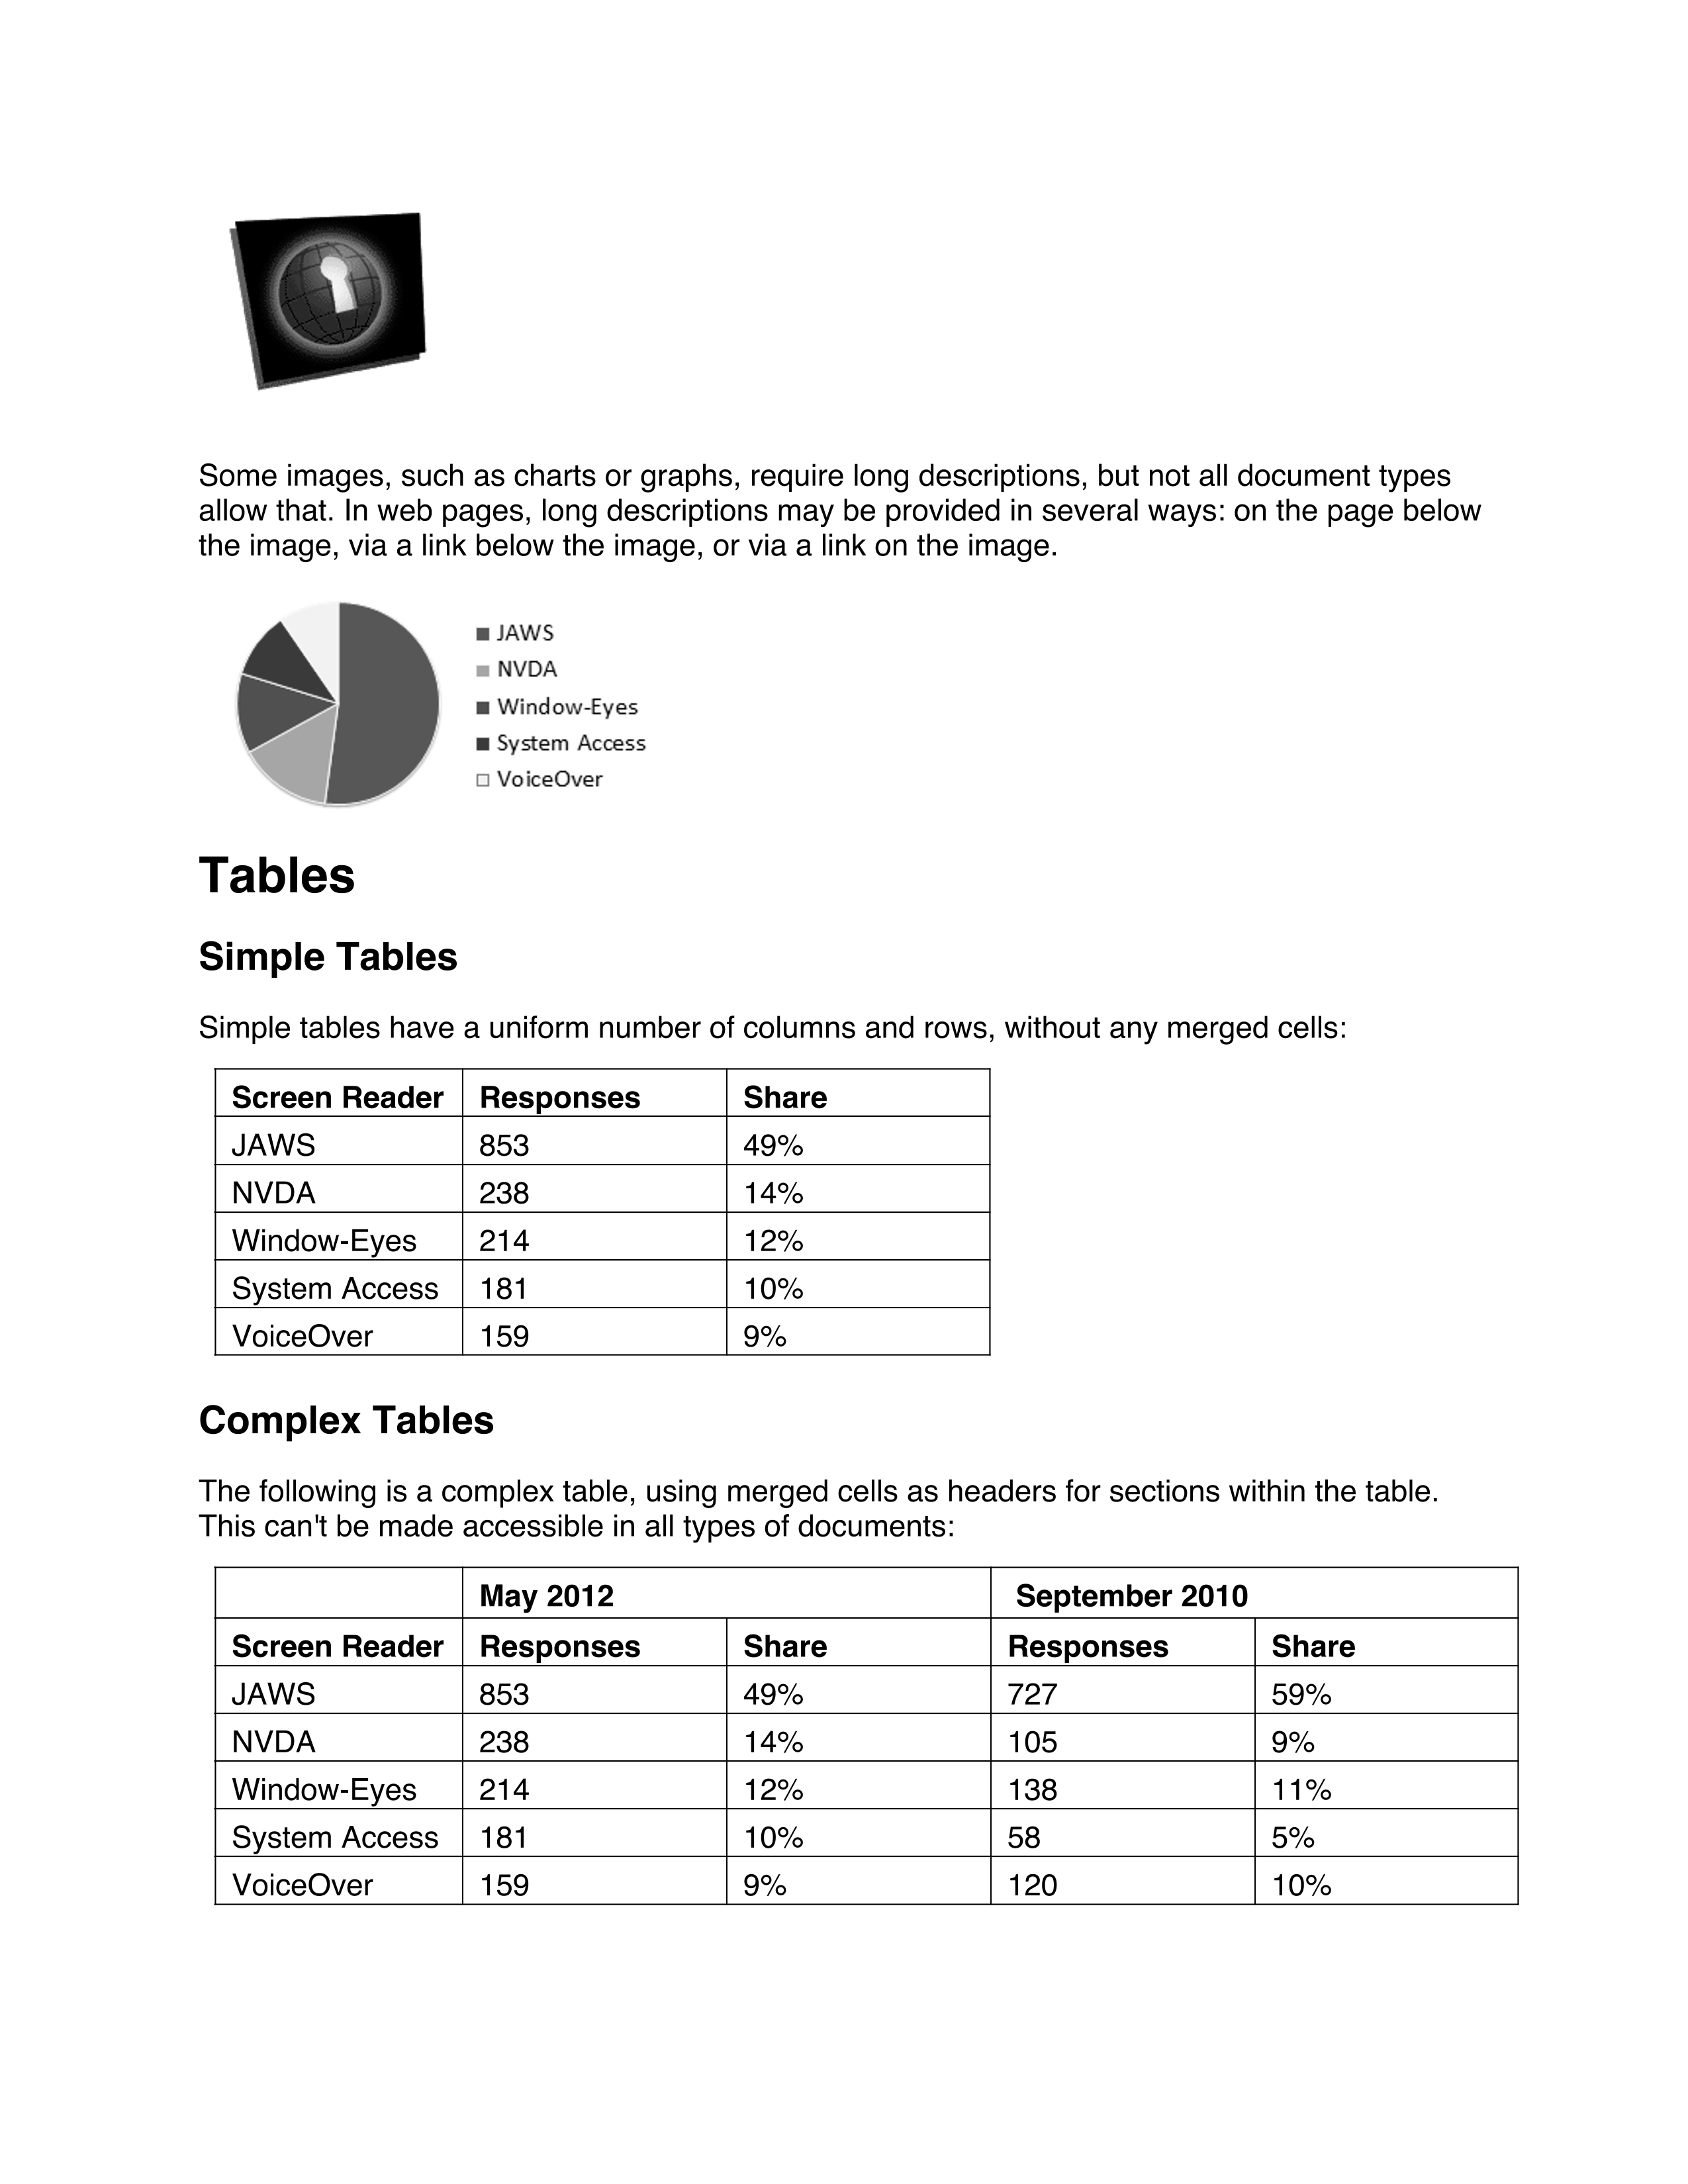

Image:
        origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/docs/doc2.docx 
        width: 2550
        height: 3299
        mode: 10


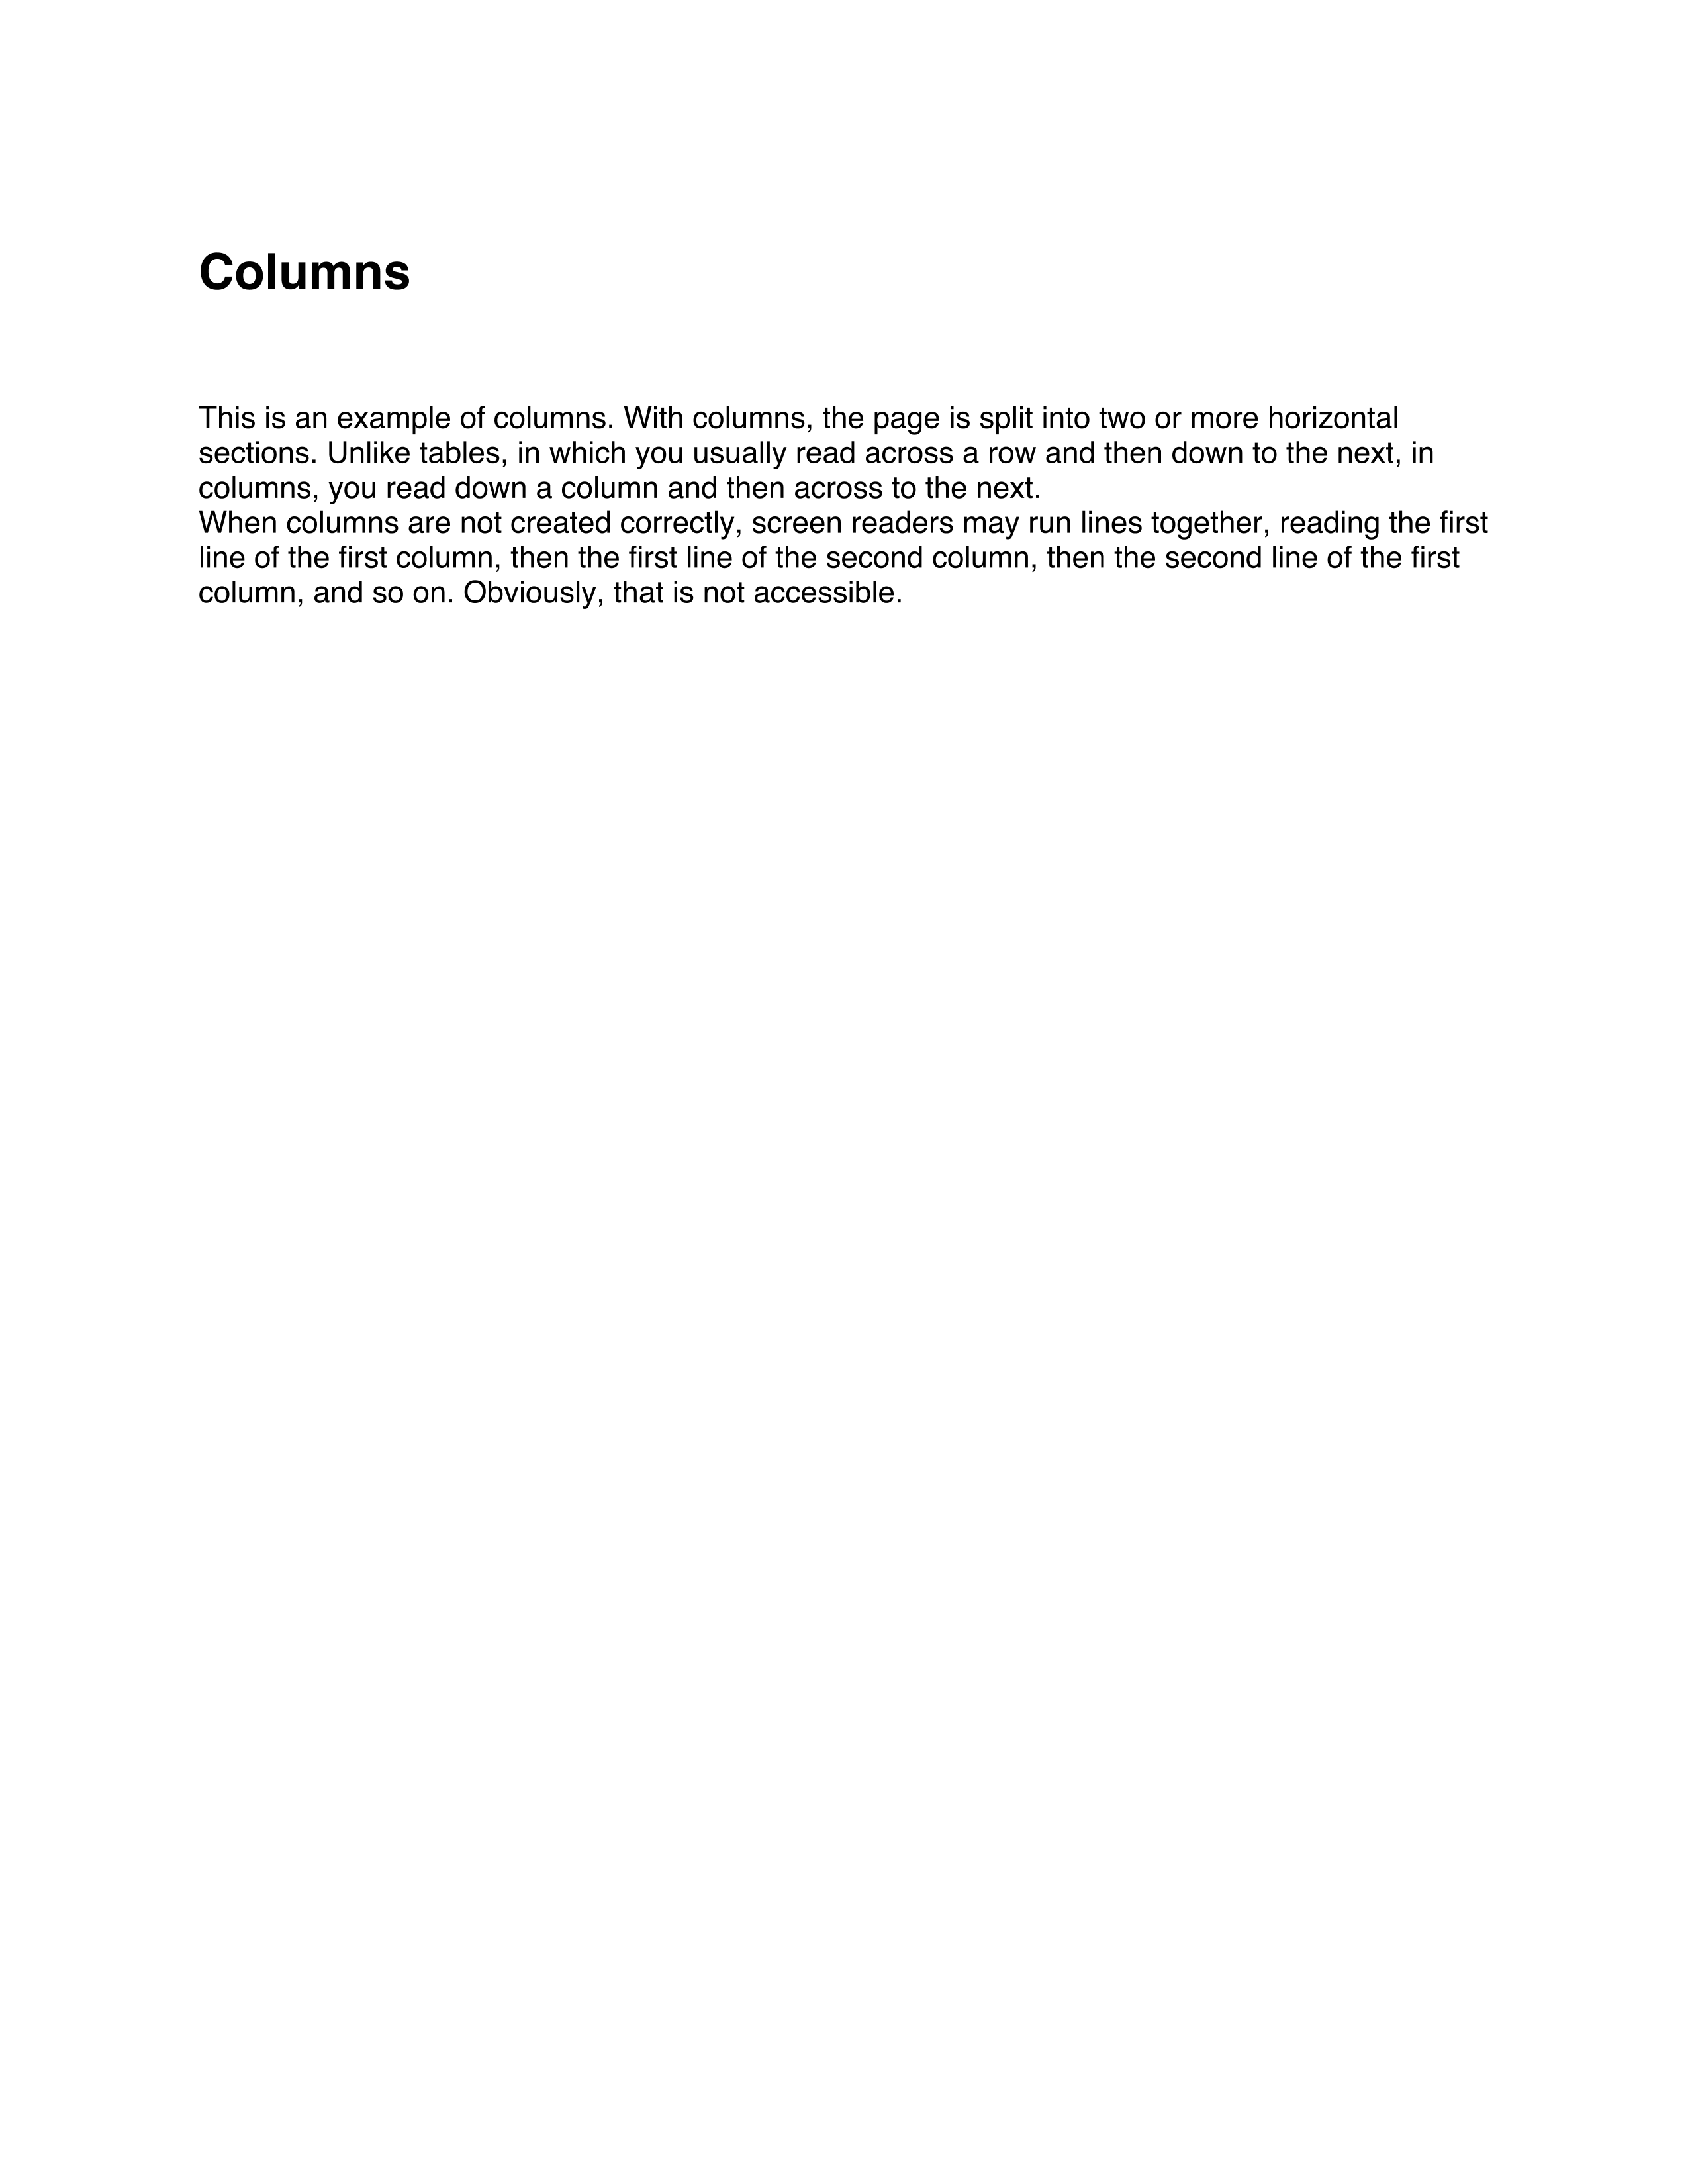

In [11]:
image_df = PdfToImage().transform(DocToPdf().setOutputCol("content").transform(doc_example_df))
for r in image_df.select("image").collect():
    display_image(r.image)

## Extract text using `DocToText` transformer

In [8]:
doc_to_table = DocToTextTable()
doc_to_table.setInputCol("content")
doc_to_table.setOutputCol("tables")

result = doc_to_table.transform(doc_example_df)

## Display result DataFrame

In [9]:
result.show()

+--------------------+-------------------+------+--------------------+---------+
|                path|   modificationTime|length|              tables|exception|
+--------------------+-------------------+------+--------------------+---------+
|file:/Users/nmeln...|2021-01-15 20:26:23| 33260|[[0, 0, 0.0, 0.0,...|     null|
|file:/Users/nmeln...|2021-01-15 20:26:23| 33260|[[1, 0, 0.0, 0.0,...|     null|
+--------------------+-------------------+------+--------------------+---------+



## Display extracted text of cell from second row and first column

In [10]:
result.select(result["tables.chunks"].getItem(1)["chunkText"][0]).show()

+-------------------------------------------+
|tables.chunks AS chunks#157[1].chunkText[0]|
+-------------------------------------------+
|                                       JAWS|
|                              Screen Reader|
+-------------------------------------------+



## Display extracted data in JSON format

In [12]:
import json
df_json = result.select("tables").toJSON()
for row in df_json.collect():
    print(json.dumps(json.loads(row), indent=4))

{
    "tables": {
        "area": {
            "index": 0,
            "page": 0,
            "x": 0.0,
            "y": 0.0,
            "width": 0.0,
            "height": 0.0
        },
        "chunks": [
            [
                {
                    "chunkText": "Screen Reader",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 90.0,
                    "height": 0.0
                },
                {
                    "chunkText": "Responses",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 95.75,
                    "height": 0.0
                },
                {
                    "chunkText": "Share",
                    "x": 0.0,
                    "y": 0.0,
                    "width": 95.75,
                    "height": 0.0
                }
            ],
            [
                {
                    "chunkText": "JAWS",
                    "x": 0.0,
                    "